# Sentiment Analysis: EDA and model testing

Our project aims at deploying a sentiment prediction API

In this notebook we will first conduct our EDA and then evaluate different approaches

In [2]:
# classic Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import shutil
import joblib
import json

# NLTK imports
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# sklearn import 
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

"""# librairies for NLP
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences"""

import gensim
from gensim.models import FastText

#pytorch
from torch.utils.data import Dataset

# Bert
import transformers
from transformers import TFAutoModel
from transformers import AutoTokenizer



In [3]:
#DATA DOC FROM DATASOURCE (Kaggle)
"""

    target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
    ids: The id of the tweet ( 2087)
    date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
    flag: The query (lyx). If there is no query, then this value is NO_QUERY.
    user: the user that tweeted (robotickilldozr)
    text: the text of the tweet (Lyx is cool)

"""
print()#used to not print documentation. Not pretty but effective

In [4]:
#have to specify header=None because columns names are not implemented correctly
columns_names = ["target","id","date","flag","user","text"]
full_data = pd.read_csv("data/training.1600000.processed.noemoticon.csv", header=None, encoding='latin-1',names=columns_names)
full_data.shape

(1600000, 6)

In [5]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
full_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
print("Number of unique items : ", full_data["target"].nunique(), "\n",
      "List of unique items : ",full_data["target"].unique())

Number of unique items :  2 
 List of unique items :  [0 4]


Need to clean "target" 

In [9]:
full_data.replace({0: "negative", 4: "positive"}, inplace=True)

In [10]:
full_data["target"].value_counts()

target
negative    800000
positive    800000
Name: count, dtype: int64

In [11]:
full_data.describe(include="all")

,target,id,date,flag,user,text
count,1600000,1.600000e+06,1600000,1600000,1600000,1600000
unique,2,NaN,774363,1,659775,1581466
top,negative,NaN,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,800000,NaN,20,1600000,549,210
mean,NaN,1.998818e+09,NaN,NaN,NaN,NaN
std,NaN,1.935761e+08,NaN,NaN,NaN,NaN
min,NaN,1.467810e+09,NaN,NaN,NaN,NaN
25%,NaN,1.956916e+09,NaN,NaN,NaN,NaN
50%,NaN,2.002102e+09,NaN,NaN,NaN,NaN
75%,NaN,2.177059e+09,NaN,NaN,NaN,NaN


In [12]:
full_data["target"].isna().value_counts()

target
False    1600000
Name: count, dtype: int64

In [13]:
full_data["text"].isna().value_counts()

text
False    1600000
Name: count, dtype: int64

Our 'target' feature is balanced, with no missing values \
Our text has no missing values either \
It seems we can move on without much cleaning

In [15]:
# Take 1% of the data for research and then scale up
data = full_data.sample(frac=0.01, random_state=42, ignore_index=True)  
#data = data.reset_index(drop=True)

In [16]:
#checking 
data["target"].value_counts()

target
positive    8018
negative    7982
Name: count, dtype: int64

In [17]:
data.head()

,target,id,date,flag,user,text
0,negative,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,negative,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
2,negative,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
3,negative,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
4,negative,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


In [18]:
data.to_csv("data/data_sample.csv")

## Text pre_treatment

In [20]:
data.text

0                   @chrishasboobs AHHH I HOPE YOUR OK!!! 
1        @misstoriblack cool , i have no tweet apps  fo...
2        @TiannaChaos i know  just family drama. its la...
3        School email won't open  and I have geography ...
4                                   upper airways problem 
                               ...                        
15995                          On my way to my last exam. 
15996    so, you should go check this guy out, he's pre...
15997    enjoyed a wonderful weekend with my princess &...
15998    got a sore throat  well its not really sore, j...
15999    Just uploading tracks off the new album 'Islan...
Name: text, Length: 16000, dtype: object

In [21]:
# To understand what we are dealing with, let's see the first description
desc = data.text[0]
desc

'@chrishasboobs AHHH I HOPE YOUR OK!!! '

The very first is an interessting case. It is an answer to a tweet including a picture. \
This should be ignored when analyzing tweet \
NOTE TO SELF : prepare a RegEx to ignore or clean out images

In [23]:
# define a RegExp to tokenize only alphanumerics
tokenizer = nltk.RegexpTokenizer(r'\w+')
list_of_words = tokenizer.tokenize(desc)
list_of_words

['chrishasboobs', 'AHHH', 'I', 'HOPE', 'YOUR', 'OK']

This will not exclude images

In [25]:
# lower all characters
lowered_list = [w.lower() for w in list_of_words]
lowered_list
#len(lowered_list)

['chrishasboobs', 'ahhh', 'i', 'hope', 'your', 'ok']

Do we really want to lower_case all characters ? Emphasis can be derived by full caps comments, maybe it should be kept

In [27]:
# stopwords exploration
len(nltk.corpus.stopwords.words('english'))

# stopwords suppression
def stop_word_filter(list_words) :
    stop_w = nltk.corpus.stopwords.words('english')
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

filtered_list = stop_word_filter(lowered_list)
filtered_list
#len(filtered_list)

['chrishasboobs', 'ahhh', 'hope']

We will use lemmatization here \
Tweet are already quite short, and stemming them would be faster but would lose us precious information

In [29]:
def lemmat(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

lemmat_list = lemmat(filtered_list)
lemmat_list
#len(lemmat_list)

['chrishasboobs', 'ahhh', 'hope']

In [30]:
transf_text = ' '.join(lemmat_list)
transf_text

'chrishasboobs ahhh hope'

In [31]:
# Define a treatment function that will be usable on the whole dataset

def cleaning_description_lemmat(text) :
    # Tools used reminder :
    # tokenizer = nltk.RegexpTokenizer(r'\w+')
    # stop_w = nltk.corpus.stopwords.words('english')
    # lemmatizer = WordNetLemmatizer()
    
    list_of_words = tokenizer.tokenize(text)
    lowered_list = [w.lower() for w in list_of_words]
    filtered_list = stop_word_filter(lowered_list)
    lemmat_list = lemmat(filtered_list)
    transformed_text = ' '.join(lemmat_list)

    return transformed_text

In [57]:
#let's compare our origin and treated text
text = data["text"][0]
test = cleaning_description_lemmat(text)
print(text, '\n', test)

@chrishasboobs AHHH I HOPE YOUR OK!!!  
 chrishasboobs ahhh hope


In [100]:
#will be used to scale at full dataset
"""from joblib import Parallel, delayed

# Function to process a chunk of data
def process_chunk(chunk):
    chunk['cleaned_text'] = chunk['text'].apply(cleaning_description_lemmat)
    return chunk

# Break your data into smaller chunks and process them in parallel
data_chunks = np.array_split(data, 10)  # Split data into 10 chunks

# Use parallel processing to clean the text
results = Parallel(n_jobs=-1)(delayed(process_chunk)(chunk) for chunk in data_chunks)

# Combine the results back into a single dataframe
cleaned_data = pd.concat(results)
#took 321 seconds"""
print()

In [101]:
data['cleaned_text'] = data['text'].apply(lambda x : cleaning_description_lemmat(x))

In [102]:
data.head()

,target,id,date,flag,user,text,cleaned_text
0,negative,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!,chrishasboobs ahhh hope
1,negative,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo...",misstoriblack cool tweet apps razr
2,negative,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...,tiannachaos know family drama lame hey next ti...
3,negative,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...,school email open geography stuff revise stupi...
4,negative,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem,upper airway problem


## Bag Of Word

In [104]:
# How important is the bag of word ?

#x = data['cleaned_text'].apply(lambda x : len(word_tokenize(x)))
#print("max length bow : ", x)

In [105]:
# create bag of words Tf-idf

ctf = TfidfVectorizer(stop_words='english', max_features=10000)

ctf_transform = ctf.fit_transform(data['cleaned_text'])

In [106]:
ctf_transform

<16000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 89148 stored elements in Compressed Sparse Row format>

In [107]:
"""# PCA to reduce dimensions
pca = PCA(svd_solver='arpack')
pca.fit(ctf_transform)"""
#ill adapted to a large dataset

"# PCA to reduce dimensions\npca = PCA(svd_solver='arpack')\npca.fit(ctf_transform)"

In [108]:
tsne = TSNE(init='random')

TSNE_ctf_transform_2 = tsne.fit_transform(ctf_transform)
TSNE_ctf_transform_2.shape

(16000, 2)

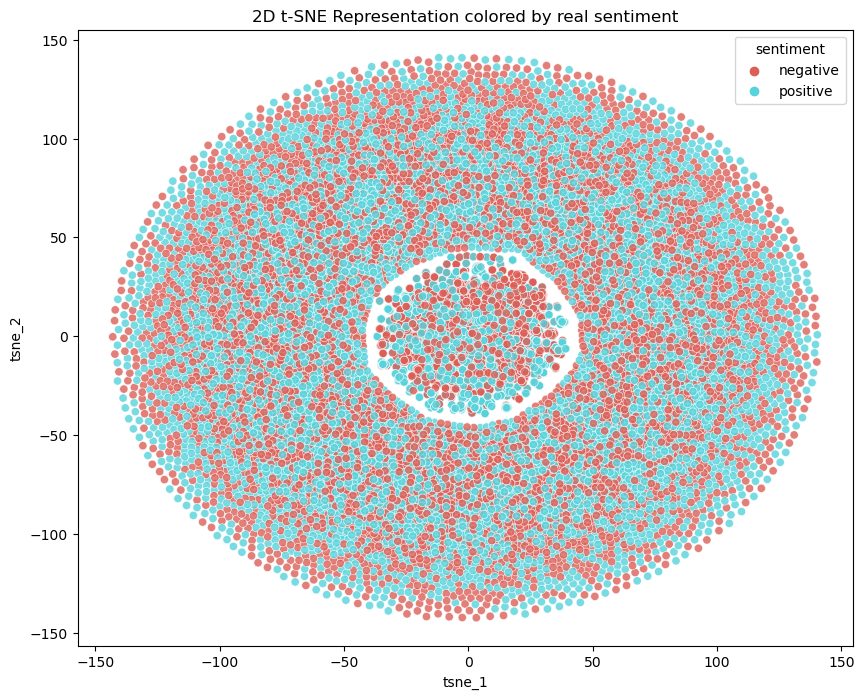

In [109]:
sentiment = data['target']

df_real_sentiment = pd.DataFrame({
    'tsne_1': TSNE_ctf_transform_2[:, 0],
    'tsne_2': TSNE_ctf_transform_2[:, 1],
    'sentiment': sentiment
})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='tsne_1', y='tsne_2', 
    hue='sentiment',
    palette=sns.color_palette('hls', len(df_real_sentiment['sentiment'].unique())),
    data=df_real_sentiment,
    legend='full',
    alpha=0.8
)
plt.title('2D t-SNE Representation colored by real sentiment')
plt.show()

In [110]:
from sklearn.model_selection import train_test_split

X = data['cleaned_text']
y = data['target']

# Initial split to create a test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Second split to create validation set from the train+validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # Limit the number of features to avoid overfitting
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Logisitc Regression Baseline with tf-idf

In [113]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

def train_model(model, params, scores, X, y):
    '''
    Train model with CV and grid search.
            Parameters:
                    model: model's initialization
                    params : model's hyperparametres
                    X, y : Data to train
            Returns:
                    grid search results
    '''
    pipeline = Pipeline(steps=[
        ['classifier', model]
    ])
    grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=params,
                           scoring=scores,
                           refit='accuracy',
                           n_jobs=-1)

    return grid_search.fit(X,y)

In [114]:
clf = LogisticRegressionCV(random_state=42, max_iter=1000)
params = {'classifier__cv' : [5, 10], 
                'classifier__Cs' : [1, 10, 100],
               'classifier__penalty':['l2']}
scores = {'roc_auc':'roc_auc', 
          'accuracy':'accuracy',
          'precision':'precision',
          'recall':'recall'}

In [115]:
# Launch gridsearch + track time
t0 = time.time()
tfidf_model_search = train_model(clf, params, scores, X_train_tfidf, y_train)
t1 = time.time()-t0
tfidf_model_search

C:\Users\kanam\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[['classifier',
                                        LogisticRegressionCV(max_iter=1000,
                                                             random_state=42)]]),
             n_jobs=-1,
             param_grid={'classifier__Cs': [1, 10, 100],
                         'classifier__cv': [5, 10],
                         'classifier__penalty': ['l2']},
             refit='accuracy',
             scoring={'accuracy': 'accuracy', 'precision': 'precision',
                      'recall': 'recall', 'roc_auc': 'roc_auc'})

In [116]:
best_pipeline = tfidf_model_search.best_estimator_
tfidf_model = best_pipeline.named_steps['classifier']
best_params = tfidf_model_search.best_params_

In [117]:
# Predict on the test set
y_pred = tfidf_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, tfidf_model.predict_proba(X_test_tfidf)[:, 1])

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

print(f"ROC-AUC: {roc_auc}")
print(f"Accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"f1: {f1}")
print(f"recall: {recall}")

print(classification_report(y_test, y_pred))

Confusion Matrix:
[[1158  438]
 [ 389 1215]]
ROC-AUC: 0.8161269757935987
Accuracy: 0.7415625
precision: 0.7417863976527369
f1: 0.7414804755923046
recall: 0.7415226032662704
              precision    recall  f1-score   support

    negative       0.75      0.73      0.74      1596
    positive       0.74      0.76      0.75      1604

    accuracy                           0.74      3200
   macro avg       0.74      0.74      0.74      3200
weighted avg       0.74      0.74      0.74      3200



In [118]:
testing_sentence = ["horrible"]
testing_sentence_tfidf = tfidf_vectorizer.transform(testing_sentence)

print(tfidf_model.predict_proba(testing_sentence_tfidf),tfidf_model.predict(testing_sentence_tfidf))

[[0.75333189 0.24666811]] ['negative']


In [242]:
testing_sentence = ["I love it"]
testing_sentence_tfidf = tfidf_vectorizer.transform(testing_sentence)

sentimentX = tfidf_model.predict(testing_sentence_tfidf)
probs = tfidf_model.predict_proba(testing_sentence_tfidf)[0]
conf = max(probs)
sentiment = "Positive" if sentimentX == 'positive' else "Negative"
print(sentiment, conf)

Positive 0.936900822017242


Some words that are not seen in training (such as other languages) still returns a 'positive' result

This could be explained by a slight bias towards positive class

#### save embedded vocabulary 

In [144]:
#import json

# Export TF-IDF vocabulary
# ! some numpy.int are to be converted into Python accepted types !
vocab_dict = {key: int(value) for key, value in tfidf_vectorizer.vocabulary_.items()}

# JSON save
vocab_path = "model_in_progress/tf_idf_LR/tfidf_vocab.json"
with open(vocab_path, "w") as f:
    json.dump(vocab_dict, f)

#### set MLFlow to track tf-idf model

In [147]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

mlflow.set_tracking_uri("file:///C:/Users/kanam/Desktop/AI-Engineer-OCR/Projet_7_sentiments_analysis/OCR_AI_Engineer_P7/mlruns")

mlflow.set_experiment("Sentiment Analysis - Logistic Regression")

<Experiment: artifact_location='file:///C:/Users/kanam/Desktop/AI-Engineer-OCR/Projet_7_sentiments_analysis/OCR_AI_Engineer_P7/mlruns/476960585432764298', creation_time=1736889389478, experiment_id='476960585432764298', last_update_time=1736889389478, lifecycle_stage='active', name='Sentiment Analysis - Logistic Regression', tags={}>

In [148]:
#mlflow ui --backend-store-uri file:///C:/Users/kanam/Desktop/AI-Engineer-OCR/Projet_7_sentiments_analysis/OCR_AI_Engineer_P7/mlruns

In [184]:
# Infer signature and create input example
input_example = X_test_tfidf[0].toarray()
signature = infer_signature(X_test_tfidf, tfidf_model.predict(X_test_tfidf))

with mlflow.start_run():
    # Log hyperparams
    mlflow.log_param("features", 10000)
    mlflow.log_param("model", "tf-idf Logistic Regression")
    mlflow.log_param("params", best_params)
    mlflow.log_param("time", t1)
    
    # Log metrics
    """mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("ROC_AUC", roc_auc)"""
    mlflow.log_metrics({"accuracy": accuracy, 
                        "ROC_AUC": roc_auc,
                        "precision": precision,
                        "recall": recall
                       })
    
    # Log model
    mlflow.sklearn.log_model(tfidf_model, "model", input_example=input_example,
    signature=signature)

    
    # Log artefact (vocab)
    vocab_path = "./model_in_progress/tf_idf_LR/tfidf_vocab.json"
    with open(vocab_path, "w") as f:
        f.write(str(tfidf_vectorizer.vocabulary_))
    mlflow.log_artifact(vocab_path)

In [186]:
#Don't forget to create PKL files to load in API ! 
#import model and vocab as pkl files
import joblib

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, "./model_in_progress/tf_idf_LR/tfidf_vectorizer.pkl")

# Save the trained logistic regression model
joblib.dump(tfidf_model, "./model_in_progress/tf_idf_LR/tf_idf_LR_model.pkl")

['./model_in_progress/tf_idf_LR/tf_idf_LR_model.pkl']

## FastText approach

In [188]:
import gensim
from gensim.models import FastText

# Step 1: Tokenize sentences
sentences = [gensim.utils.simple_preprocess(text) for text in X_train]  # Tokenize X_train text data
#sentences = X_train
# Step 2: Init FastText model
fasttext_model = FastText(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1)

# Step 3: Build vocabulary
fasttext_model.build_vocab(sentences)

# Train the FastText model
fasttext_model.train(sentences, total_examples=len(sentences), epochs=10)


(662015, 702230)

In [189]:
def get_sentence_embedding(sentence, model):
    """
    Generate a sentence embedding by averaging FastText word embeddings.
    Parameters:
        sentence: List of words (tokenized sentence).
        model: Trained FastText model.
    Returns:
        A vector representing the sentence.
    """
    valid_words = [word for word in sentence if word in model.wv]
    if valid_words:
        return np.mean([model.wv[word] for word in valid_words], axis=0)
    else:
        return np.zeros(model.vector_size)

# Create embeddings for train and validation sets
X_train_fasttext = np.array([get_sentence_embedding(sentence, fasttext_model) for sentence in sentences])

# For the validation set
sentences_val = [gensim.utils.simple_preprocess(text) for text in X_val]
X_val_fasttext = np.array([get_sentence_embedding(sentence, fasttext_model) for sentence in sentences_val])


In [190]:
# Initialize and train the classifier + track time
t0 = time.time()
fast_classifier_search = train_model(clf, params, scores, X_train_fasttext, y_train)
t1 = time.time()-t0
fast_classifier_search

C:\Users\kanam\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[['classifier',
                                        LogisticRegressionCV(max_iter=1000,
                                                             random_state=42)]]),
             n_jobs=-1,
             param_grid={'classifier__Cs': [1, 10, 100],
                         'classifier__cv': [5, 10],
                         'classifier__penalty': ['l2']},
             refit='accuracy',
             scoring={'accuracy': 'accuracy', 'precision': 'precision',
                      'recall': 'recall', 'roc_auc': 'roc_auc'})

In [191]:
best_pipeline = fast_classifier_search.best_estimator_
fast_model = best_pipeline.named_steps['classifier']
ft_best_params = fast_classifier_search.best_params_

In [192]:
# Evaluate on the validation set
y_val_pred = fast_model.predict(X_val_fasttext)

# Display metrics
accuracy_ft = accuracy_score(y_val, y_val_pred)
precision_ft = precision_score(y_val, y_val_pred, average="macro")
f1_ft = f1_score(y_val, y_val_pred, average="macro")
recall_ft = recall_score(y_val, y_val_pred, average="macro")

# ROC-AUC Score
roc_auc_ft = roc_auc_score(y_val, fast_model.predict_proba(X_val_fasttext)[:, 1])

print(f"acc:{accuracy_ft}, prec:{precision_ft}, f1:{f1_ft}, rec:{recall_ft}, roc:{roc_auc_ft}")

acc:0.669375, prec:0.6697425246470008, f1:0.6691577555418227, rec:0.6693293062358423, roc:0.7347762160101344


In [193]:
# Function to predict sentiment for a new text input
def predict_sentiment(text, model, classifier):
    
    # Generate sentence embedding using FastText model
    embedding = get_sentence_embedding(text, model)
    
    # Reshape for prediction (1 sample with vector size)
    embedding = embedding.reshape(1, -1)
    
    # Predict sentiment
    prediction = fast_model.predict(embedding)
    proba = fast_model.predict_proba(embedding)

    return prediction, proba

# Test the function with a random text
random_text = "I had a wonderful experience with Air Paradis!"
pred, prob = predict_sentiment(random_text, fasttext_model, fast_model)
print(f"Predicted Sentiment is {pred} with probability of {prob}")


Predicted Sentiment is ['positive'] with probability of [[0.24246295 0.75753705]]


The results are interesting, maybe model will be kept \
Try with not lemmat ?

In [195]:
#MLFlow log fasttext+logisticReg
input_example = X_val_fasttext[0]
signature = infer_signature(X_val_fasttext, fast_model.predict(X_val_fasttext))

with mlflow.start_run():
    # Log des hyperparamètres
    #mlflow.log_param("embedding_dim", 100)
    #mlflow.log_param("fasttext_loss", "softmax")
    mlflow.log_param("model", "Fasttext + Logistic Regression")
    mlflow.log_param("params", ft_best_params)
    mlflow.log_param("time", t1)

    # Log des métriques
    mlflow.log_metrics({
        "accuracy": accuracy_ft,
        "ROC_AUC": roc_auc_ft,
        "precision_macro": precision_ft,
        "recall_macro": recall_ft
    })

    # Log FastText
    fasttext_model_path = "./model_in_progress/FastText_LR/fasttext_model.bin"
    fasttext_model.save(fasttext_model_path)
    mlflow.log_artifact(fasttext_model_path)
    # Log  model
    mlflow.sklearn.log_model(fast_model, "FastText + logistic regression model", input_example=input_example,
    signature=signature)

    # Log artefacts
    fasttext_vocab_path = "./model_in_progress/FastText_LR/fasttext_vocab.txt"
    with open(fasttext_vocab_path, "w") as f:
        vocab = list(fasttext_model.wv.index_to_key)
        f.write("\n".join(vocab))
    mlflow.log_artifact(fasttext_vocab_path)


2025/01/28 11:40:18 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": [
    -0.45253127813339233,
    -0.1116253137588501,
    -0.5481312870979309,
    0.23031525313854218,
    0.10796613991260529,
    0.3189166784286499,
    -0.26067209243774414,
    0.49209508299827576,
    0.6499971151351929,
    -0.044499896466732025,
    -0.40128594636917114,
    -0.16900058090686798,
    -0.2396952211856842,
    0.8446393013000488,
    0.2512594163417816,
    -0.2806127071380615,
    -0.2736263871192932,
    -0.5569757223129272,
    -0.3345308303833008,
    -0.5397427082061768,
    -0.9787591099739075,
    -0.24042561650276184,
    -0.6294782757759094,
    0.004908268805593252,
    -0.22337286174297333,
    0.049738768488168716,
    -0.1104016900062561,
    0.23818430304527283,
    0.5022231340408325,
    0.02024049684405327,
    -0.2283855378627777,
    0.18069668114185333,
    0.19186806678771973,
    0.3488929867744446,
    0.23900501430034637,
    0.104350447

## Roberta pre-trained

In [197]:
import re
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch.optim as optim

In [198]:
# Tokenize with roberta and class creation

df = data
# Load tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# put target to numerical
y_train = y_train.map({'positive': 1, 'negative': 0})
y_val = y_val.map({'positive': 1, 'negative': 0})    

# Tokenize texts
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True)

# Create dataset class
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = TweetDataset(train_encodings, y_train)
val_dataset = TweetDataset(val_encodings, y_val)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [199]:
# Model training

# Training parameters
num_epochs = 3
batch_size = 16
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Training loop + tracking time
t0 = time.time()

model.train()
for epoch in range(num_epochs):
    for i in range(0, len(train_dataset), batch_size):
        batch = train_dataset[i:i + batch_size]
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()       
        """if i % 100 == 0:
            print(f"Epoch {epoch}, Batch {i}, Loss: {loss.item()}")"""
        
t1 = time.time()-t0

# Evaluation
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for i in range(0, len(val_dataset), batch_size):
        batch = val_dataset[i:i + batch_size]
        outputs = model(**batch)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).tolist())
        true_labels.extend(batch['labels'].tolist())

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
roc_auc = roc_auc_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)

print(f"Accuracy: {accuracy}, F1: {f1}, ROC AUC: {roc_auc}, Precision: {precision}, total training time :{t1}")

Accuracy: 0.5009375, F1: 0.6674994794919842, ROC AUC: 0.5, Precision: 0.5009375, total training time :3468.2713775634766


In [200]:
# Test sentence
sentence = "Amazing"

# Tokenize the input sentence
inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=64)

# Get model prediction
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits # logits=model(**inputs)
    probabilities = torch.softmax(logits, dim=-1)
    prediction = torch.argmax(probabilities, dim=-1).item()

pred = 'positive' if prediction == 1 else 'negative'

# Output the prediction
print(f"Sentence: {sentence}")
print(f"Predicted class: {pred}")
print(f"Probabilities: {probabilities}")

Sentence: Amazing
Predicted class: positive
Probabilities: tensor([[0.4597, 0.5403]])


This took 4000 secs

It seems that precision is barely acceptable with pre-trained model.
It also looks like the model is always predicting the same result, showing no sign of learning

We'll try to train a BERT model with trasnfer learning and then another with a LSTM layer

## Transfer learning by adding weight

In [203]:
from torch import nn
from transformers import RobertaModel
from torch.utils.data import Dataset, DataLoader

# Resetting indices
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Dataset class to handle tokenization
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create dataset instances
train_dataset = SentimentDataset(X_train, y_train, tokenizer)
val_dataset = SentimentDataset(X_val, y_val, tokenizer)
test_dataset = SentimentDataset(X_test, y_test, tokenizer)

class CustomRobertaModel(nn.Module):
    def __init__(self, roberta_model_name="roberta-base", num_labels=2, dropout_rate=0.3):
        super(CustomRobertaModel, self).__init__()
        # Load the pre-trained RoBERTa model
        self.roberta = RobertaModel.from_pretrained(roberta_model_name)

        # Add a dropout layer and a classification head
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        # Forward pass through RoBERTa
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # CLS token representation

        # Pass through dropout and classification head
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits


In [204]:
# Define batch size and epochs
"""num_epochs = 3
batch_size = 16
"""
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [205]:
# Initialize the model
model = CustomRobertaModel(num_labels=2)

# Freeze all parameters in the pre-trained RoBERTa layers
for param in model.roberta.parameters():
    param.requires_grad = False


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [206]:
from torch.optim import AdamW

# Define optimizer and loss function
optimizer = AdamW(model.classifier.parameters(), lr=1e-3)  # Train only the classification head
criterion = nn.CrossEntropyLoss()

# Training loop + tracking time
t0 = time.time()

model.train()
for epoch in range(num_epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        
        # dataset
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]
        
        # Forward pass
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
t1 = time.time()-t0

In [207]:
#model evaluation

model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in val_loader: 
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        # Passage avant
        logits = model(input_ids=input_ids, attention_mask=attention_mask)

        # Prédictions
        preds = torch.argmax(logits, dim=-1)
        predictions.extend(preds.tolist())
        true_labels.extend(labels.tolist())

# Calculate metrics
accuracy_rb_tl = accuracy_score(true_labels, predictions)
f1_rb_tl = f1_score(true_labels, predictions, average='weighted')  # Specify average method
roc_auc_rb_tl = roc_auc_score(true_labels, predictions)
precision_rb_tl = precision_score(true_labels, predictions, average='weighted')  # Specify average method

print(f"Accuracy: {accuracy}, F1: {f1}, ROC AUC: {roc_auc}, Precision: {precision}")

Accuracy: 0.5009375, F1: 0.6674994794919842, ROC AUC: 0.5, Precision: 0.5009375


C:\Users\kanam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [208]:
# Test sentence
sentence = "This was an awfull experience"

# Tokenize the input sentence
inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=64)

# Get model prediction
model.eval()
with torch.no_grad():
    logits = model(**inputs)
    probabilities = torch.softmax(logits, dim=-1)
    prediction = torch.argmax(probabilities, dim=-1).item()

pred = 'positive' if prediction == 1 else 'negative'

# Output the prediction
print(f"Sentence: {sentence}")
print(f"Predicted class: {pred}")
print(f"Probabilities: {probabilities}")

Sentence: This was an awfull experience
Predicted class: positive
Probabilities: tensor([[0.4274, 0.5726]])


In [209]:
#trackin roberta_TL

with mlflow.start_run():
    # Log des hyperparamètres
    mlflow.log_param("epochs", num_epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("learning_rate", 1e-3)
    mlflow.log_param("model", "roberta-base_transfer-learning")
    mlflow.log_param("max_len", 128)
    mlflow.log_param("time", t1)

    # Log des métriques
    mlflow.log_metrics({
        "accuracy": accuracy_rb_tl,
        "ROC_AUC": roc_auc_rb_tl,
        "precision_macro": precision_rb_tl,
        "f1": f1_rb_tl
    })

    # Log du modèle roBERTa
    roberta_model_path = "./model_in_progress/BERT/roBERTa_TL"
    torch.save(model.state_dict(), f"{roberta_model_path}/custom_roberta_model.pth")
    tokenizer.save_pretrained(roberta_model_path)
"""    # Log du modèle
    mlflow.sklearn.log_model(model, "FastText + logistic regression model", input_example=input_example,
    signature=signature)"""

"""    # Log des artefacts supplémentaires (ex. FastText vocab)
    fasttext_vocab_path = "./model_in_progress/FastText_LR/fasttext_vocab.txt"
    with open(fasttext_vocab_path, "w") as f:
        vocab = list(fasttext_model.wv.index_to_key)
        f.write("\n".join(vocab))
    mlflow.log_artifact(fasttext_vocab_path)"""

'    # Log des artefacts supplémentaires (ex. FastText vocab)\n    fasttext_vocab_path = "./model_in_progress/FastText_LR/fasttext_vocab.txt"\n    with open(fasttext_vocab_path, "w") as f:\n        vocab = list(fasttext_model.wv.index_to_key)\n        f.write("\n".join(vocab))\n    mlflow.log_artifact(fasttext_vocab_path)'

barely better than previously tried model

Maybe the problem is in the data I feed in training ? Maybe I would have better result if they were unprocessed ? 

## LSTM bert-based model

In [212]:
#DataSet model
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [213]:
#DataSets
train_set = SentimentDataset(X_train, y_train, tokenizer)
val_set = SentimentDataset(X_val, y_val, tokenizer)
test_set = SentimentDataset(X_test, y_test, tokenizer)

#DataLoaders
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=True)

In [214]:
from transformers import BertModel, BertTokenizer

# Load pre-trained tokenizer and bert
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")


# Build model with LSTM layer
class SentimentModel(nn.Module):
    def __init__(self, bert_model, hidden_size=768, lstm_hidden_size=128, num_classes=2):
        super(SentimentModel, self).__init__()
        self.bert = bert_model
        
        # Couche LSTM
        self.lstm = nn.LSTM(
            input_size=hidden_size,     
            hidden_size=lstm_hidden_size, 
            batch_first=True,          
            bidirectional=True         
        )
        
        # Classifier definition
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_size * 2, 128),  # *2 because bidrectional=True
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, input_ids, attention_mask):
        # Bert output
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
        
        # Through LSTM
        lstm_output, (hidden_state, cell_state) = self.lstm(sequence_output)  
        # lstm_output: (batch_size, seq_len, lstm_hidden_size * 2)
        
        # Using hidden_last_state of both directions (concat)
        lstm_output = lstm_output[:, 0, :]  # Shape: (batch_size, lstm_hidden_size * 2)
        
        # Through classifier
        logits = self.classifier(lstm_output)
        return logits

# Optimizer and loss function
optimizer = AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [215]:
# Init model
model_lstm = SentimentModel(bert_model)

# training loop + tracking time
t0 = time.time()

model_lstm.train()
for epoch in range(num_epochs):
    for batch in train_loader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        # Reset gradients
        optimizer.zero_grad()

        # Forward
        logits = model(input_ids, attention_mask)

        # Loss compute
        loss = criterion(logits, labels)

        # backward pass
        loss.backward()

        # Weight update
        optimizer.step()
    
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

t1 = time.time()-t0

Epoch 1, Loss: 0.6710307002067566
Epoch 2, Loss: 0.6179919242858887
Epoch 3, Loss: 0.6565197706222534


In [216]:
# Evaluation
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
model_lstm.eval()

predictions, true_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        batch_input_ids = batch['input_ids']
        batch_attention_masks = batch['attention_mask']
        batch_labels = batch['label']

        # Pass forward
        logits = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)

        # Predictions and labels
        probs = torch.softmax(logits, dim=-1)[:, 1]
        batch_predictions = torch.argmax(logits, dim=-1)
        
        predictions.extend(batch_predictions.tolist())
        true_labels.extend(batch_labels.tolist())

# Metrics 
accuracy_lstm = accuracy_score(true_labels, predictions)
f1_lstm = f1_score(true_labels, predictions, average='weighted')
precision_lstm = precision_score(true_labels, predictions, average='weighted')
recall_lstm = recall_score(true_labels, predictions, average='weighted')
roc_auc_lstm = roc_auc_score(true_labels, predictions)

print(f"Accuracy: {accuracy_lstm}, F1: {f1_lstm}, ROC AUC: {roc_auc_lstm}, Precision: {precision_lstm}, Recall: {recall_lstm}")

Accuracy: 0.6525, F1: 0.6514578045977417, ROC AUC: 0.6523979967117072, Precision: 0.654212774894984, Recall: 0.6525


In [287]:
# test sentence
text = "I loved everything way better before the changes"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)

# forward pass
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]
logits = model(input_ids, attention_mask)

# results
predictions = torch.argmax(logits, dim=1)
print("Logits:", logits)
print("pred", predictions)
print("Prediction:", "Positive" if predictions.item() == 1 else "Negative")

Logits: tensor([[-0.0528,  0.0090]], grad_fn=<AddmmBackward0>)
pred tensor([1])
Prediction: Positive


In [289]:
prob = torch.nn.functional.softmax(logits, dim=1)
prob

tensor([[0.4846, 0.5154]], grad_fn=<SoftmaxBackward0>)

In [223]:
#trackin BERT_LSTM

with mlflow.start_run():
    # Log params
    mlflow.log_param("epochs", num_epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("learning_rate", 1e-3)
    mlflow.log_param("model", "BERT_LSTM")
    mlflow.log_param("max_len", 128)
    mlflow.log_param("time", t1)

    # Log metrics
    mlflow.log_metrics({
        "accuracy": accuracy_lstm,
        "ROC_AUC": roc_auc_lstm,
        "precision_macro": precision_lstm,
        "f1": f1_lstm, 
        "recall_lstm" : recall_lstm
    })

    # Log model
    bert_lstm_model_path = "./model_in_progress/BERT/BERT_LSTM"
    torch.save(model_lstm.state_dict(), f"{bert_lstm_model_path}/bert_lstm_model.pth")
    tokenizer.save_pretrained(bert_lstm_model_path)